# Heterogenous Wage Effects

## Application: Heterogeneous Effect of Gender on Wage Using Double Lasso

 We use US census data from the year 2012 to analyse the effect of gender and interaction effects of other variables with gender on wage jointly. The dependent variable is the logarithm of the wage, the target variable is *female* (in combination with other variables). All other variables denote some other socio-economic characteristics, e.g. marital status, education, and experience.  For a detailed description of the variables we refer to the help page.



This analysis allows a closer look how discrimination according to gender is related to other socio-economic variables.



In [1]:
import hdmpy
import pyreadr
import os
from urllib.request import urlopen
import patsy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import numpy as np
import scipy.linalg as sci_lag
import warnings
warnings.filterwarnings('ignore')

In [2]:
link="https://raw.githubusercontent.com/d2cml-ai/14.388_py/main/data/cps2012.RData"
response = urlopen(link)
content = response.read()
fhandle = open( 'cps2012.Rdata', 'wb')
fhandle.write(content)
fhandle.close()
result = pyreadr.read_r("cps2012.Rdata")
os.remove("cps2012.Rdata")

# Extracting the data frame from rdata_read
cps2012 = result[ 'data' ]
cps2012.describe()

,year,lnw,female,widowed,divorced,separated,nevermarried,hsd08,hsd911,hsg,cg,ad,mw,so,we,exp1,exp2,exp3,exp4,weight
count,29217.0,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000
mean,2012.0,2.797007,0.428757,0.007975,0.113393,0.016600,0.156347,0.004107,0.022179,0.247288,0.283431,0.155800,0.291645,0.282849,0.199644,18.756939,4.286811,10.875998,29.408779,1513.842566
std,0.0,0.662406,0.494907,0.088947,0.317078,0.127769,0.363191,0.063957,0.147267,0.431443,0.450671,0.362672,0.454528,0.450391,0.399740,8.767040,3.321506,11.121864,36.569919,1009.811610
min,2012.0,-7.469874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.790000
25%,2012.0,2.408296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000,1.322500,1.520875,1.749006,654.240000
50%,2012.0,2.774540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,3.610000,6.859000,13.032100,1472.100000
75%,2012.0,3.181569,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,26.000000,6.760000,17.576000,45.697600,1966.630000
max,2012.0,5.970942,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,43.500000,18.922500,82.312875,358.061006,6444.150000


In [3]:
formula_basic =  '''lnw ~ -1 + female + female:(widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3) + +(widowed +
divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
we + exp1 + exp2 + exp3) ** 2'''

y, X = patsy.dmatrices(formula_basic, cps2012, return_type='dataframe')
X.shape[1]

136

We have the same number of covariables.

In [4]:
variance_cols = X.var().to_numpy()
X = X.iloc[ : ,  np.where( variance_cols != 0   )[0] ]

def demean(x):
    dif = x - np.mean( x )
    return dif 

X = X.apply( demean, axis = 0 )

index_gender = np.where( X.columns.str.contains('female'))[0]

The parameter estimates for the target parameters, i.e. all coefficients related to gender (i.e. by interaction with other variables) are calculated and summarized by the following commands:

In [5]:
effect_female = hdmpy.rlassoEffects( x = X , y = y , index = index_gender )

In [6]:
result_coeff = pd.concat( [ effect_female.res.get( 'coefficients' ).rename(columns = { 0 : "Estimate." }) , \
             effect_female.res.get( 'se' ).rename( columns = { 0 : "Std. Error" } ) , \
             effect_female.res.get( 't' ).rename( columns = { 0 : "t value" } ) , \
             effect_female.res.get( 'pval' ).rename( columns = { 0 : "Pr(>|t|)" } ) ] ,\
             axis = 1 )

print( result_coeff )

                     Estimate.  Std. Error   t value      Pr(>|t|)
female               -0.154593    0.048599 -3.180992  1.467717e-03
female:widowed        0.136096    0.094115  1.446056  1.481614e-01
female:divorced       0.136939    0.021680  6.316402  2.677227e-10
female:separated      0.023303    0.048849  0.477034  6.333381e-01
female:nevermarried   0.186853    0.020094  9.299104  1.416347e-20
female:hsd08          0.027810    0.140357  0.198140  8.429356e-01
female:hsd911        -0.119335    0.052223 -2.285101  2.230692e-02
female:hsg           -0.012885    0.018229 -0.706850  4.796595e-01
female:cg             0.010139    0.018079  0.560797  5.749360e-01
female:ad            -0.030464    0.022807 -1.335714  1.816429e-01
female:mw            -0.001063    0.018715 -0.056822  9.546869e-01
female:so            -0.008183    0.019027 -0.430096  6.671256e-01
female:we            -0.004226    0.021422 -0.197281  8.436076e-01
female:exp1           0.004733    0.007483  0.632488  5.270682

In [7]:
t_value = stats.t.ppf(1-0.05, 29217 - 116 -1 )

In [8]:
pointwise_CI = pd.DataFrame({ '5%' : result_coeff.iloc[ : , 0 ] \
                                     - result_coeff.iloc[ : , 1 ] * t_value ,\
                              '95%' : result_coeff.iloc[ : , 0 ] \
                             + result_coeff.iloc[ : , 1 ] * t_value })
pointwise_CI

,5%,95%
female,-0.234534,-0.074652
female:widowed,-0.018715,0.290906
female:divorced,0.101278,0.172601
female:separated,-0.057050,0.103655
female:nevermarried,0.153801,0.219906
female:hsd08,-0.203064,0.258684
female:hsd911,-0.205237,-0.033433
female:hsg,-0.042869,0.017099
female:cg,-0.019599,0.039877
female:ad,-0.067979,0.007052


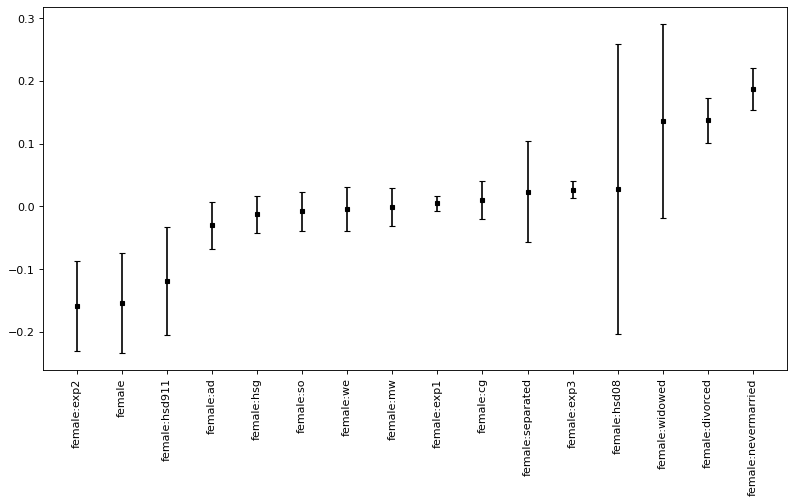

In [9]:
result_coeff = result_coeff.sort_values('Estimate.')

x = result_coeff.index

coef = result_coeff.iloc[ : , 0 ].to_numpy()

sd_error = ( result_coeff.iloc[ : , 1 ] * t_value ).to_numpy()

figure(figsize=(12, 6), dpi=80)

plt.errorbar( x = x , y = coef , yerr = sd_error , linestyle="None" , color = "black", \
              capsize = 3 , marker = "s" , markersize = 3 , mfc = "black" , mec = "black" )
plt.xticks(x, x, rotation=90)
plt.show()

Now, we estimate and plot confident intervals, first "pointwise" and then the joint confidence intervals.

In [10]:
effect_female.res.get( 'coefficients' ).iloc[ :, 0 ].to_list()

[-0.15459327318292398,
 0.13609550288296599,
 0.1369393922151194,
 0.023302771994032613,
 0.1868534864035715,
 0.02781031278454519,
 -0.1193350392182964,
 -0.01288483246151049,
 0.010138550922290069,
 -0.0304637472338405,
 -0.0010634393390657419,
 -0.0081833375950412,
 -0.0042261271189995234,
 0.004732893307323949,
 -0.15951933512469815,
 0.02651219417890157]

In [11]:
def confint_joint_python( rlassomodel , level = 0.95 ):
    
    coef = rlassomodel.res['coefficients'].to_numpy().reshape( 1 , rlassomodel.res['coefficients'].to_numpy().size )
    se = rlassomodel.res['se'].to_numpy().reshape( 1 , rlassomodel.res['se'].to_numpy().size )
    
    e = rlassomodel.res['residuals']['e']
    v = rlassomodel.res['residuals']['v']
    
    n = e.shape[0]
    k = e.shape[1]
    
    ev = e.to_numpy() * v.to_numpy()
    Ev2 = (v ** 2).mean( axis = 0 ).to_numpy()
    
    
    Omegahat = np.zeros( ( k , k ) )
    
    
    for j in range( 0 , k ):
        for l in range( 0 , k ):
            Omegahat[ j , l ] = ( 1 / ( Ev2[ j ] * Ev2[ l ] ) ) * np.mean(ev[ : , j ] * ev[ : , l ] )
            Omegahat[ l , j ] = ( 1 / ( Ev2[ j ] * Ev2[ l ] ) ) * np.mean(ev[ : , j ] * ev[ : , l ] )
    
    var = np.diagonal( Omegahat )
    
    B = 500
    sim = np.zeros( B )
    
    for i in range( 0 , B ):
        beta_i = mvrnorm( mu =  np.repeat( 0, k ) , Sigma =  Omegahat / n )
        sim[ i ] = ( np.abs( beta_i/ ( var ** 0.5 ) ) ).max()
    
    t_stat = np.quantile( sim , level )
    
    low_num = int( np.round( ( 1 - level ) / 2, 2) * 100 )
    upper_num = int( np.round( ( 1 + level ) / 2, 2) * 100 )
    
    sd_tstat = t_stat * ( var ** 0.5 )
    
    low = coef - sd_tstat
    upper = coef + sd_tstat
    
    table = pd.DataFrame( { f'{low_num}%' : low.tolist()[0] , f'{upper_num}%' : upper.tolist()[0] , \
                           'Coef.' : rlassomodel.res.get( 'coefficients' ).iloc[ :, 0 ].to_list() }, \
                         index = rlassomodel.res.get( 'coefficients' ).index )
    
    return ( table, sd_tstat )

In [12]:
def mvrnorm( mu , Sigma , n = 1 ):
    p = mu.size
    
    ev = np.linalg.eig( Sigma )[ 0 ]
    vectors = np.linalg.eig( Sigma )[ 1 ]
    
    X = np.random.normal(0, 1 ,  p * n ).reshape( n , p )
    
    diagonal = np.diag( np.maximum( ev, 0 ) ** 0.5 )
    
    Z = mu.reshape( p , 1 ) + vectors @ ( diagonal @ X.transpose())
    
    resultado = Z.transpose()
    
    return( resultado )

Finally, we compare the pointwise confidence intervals to joint confidence intervals.

In [13]:
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy.stats as st

In [14]:
joint_CI =  confint_joint_python( effect_female, level = 0.9 )[0]
size_err =  confint_joint_python( effect_female, level = 0.9 )[1]

In [15]:
joint_CI

,5%,95%,Coef.
female,-0.284484,-0.024702,-0.154593
female:widowed,-0.115446,0.387637,0.136096
female:divorced,0.078995,0.194884,0.136939
female:separated,-0.107257,0.153863,0.023303
female:nevermarried,0.133149,0.240558,0.186853
female:hsd08,-0.347323,0.402943,0.027810
female:hsd911,-0.258912,0.020242,-0.119335
female:hsg,-0.061604,0.035835,-0.012885
female:cg,-0.038181,0.058458,0.010139
female:ad,-0.091420,0.030493,-0.030464


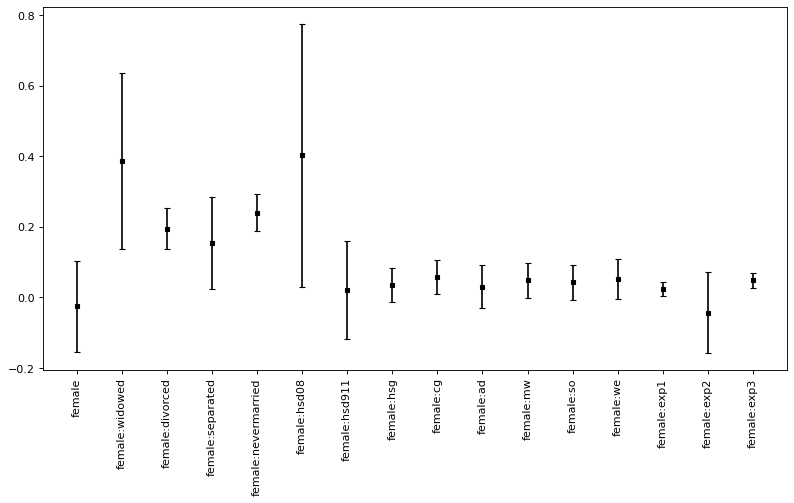

In [16]:
x = joint_CI.index

coef = joint_CI.iloc[ : , 1 ].to_numpy()

sd_error = size_err

figure(figsize=(12, 6), dpi=80)

plt.errorbar( x = x , y = coef , yerr = sd_error , linestyle="None" , color = "black", \
              capsize = 3 , marker = "s" , markersize = 3 , mfc = "black" , mec = "black" )
plt.xticks(x, x, rotation=90)
plt.show()